# Get OpenStreetMap Data

For this, we use the OSMPythonTools package as recommended by the OSM wiki. It allows us to access the Overpass API (a read-only API, perfect for what we are set to do), the OSM API, and the Nominatim access point. More info here: https://wiki.openstreetmap.org/wiki/OSMPythonTools

#### Which object does the way with the id 5887599 represent?

In [3]:
from OSMPythonTools.api import Api
api = Api()
way = api.query('way/5887599')

#### How many trees are in the OSM data of Vienna? And how many trees have there been in 2013?

In [7]:
# Find the id for the area Vienna
from OSMPythonTools.nominatim import Nominatim
nominatim = Nominatim()
areaId = nominatim.query('Vienna, Austria').areaId()
print('Vienna Id:', areaId)

Vienna Id: 3600109166


In [9]:
# query the Overpass API for the numbe of trees in Vienna using the id we just retrieved.
from OSMPythonTools.overpass import overpassQueryBuilder, Overpass
overpass = Overpass()
query = overpassQueryBuilder(area=areaId, elementType='node', selector='"natural"="tree"', out='count')
result = overpass.query(query)
print('there are', result.countElements(), 'trees in Vienna')

there are 143275 trees in Vienna


In [10]:
# How many were there in 2013 ?
result = overpass.query(query, date='2013-01-01T00:00:00Z', timeout=60)
print('there were', result.countElements(), 'trees in Vienna in 2013')

[overpass] downloading data: [timeout:60][date:"2013-01-01T00:00:00Z"][out:json];area(3600109166)->.searchArea;(node["natural"="tree"](area.searchArea);); out count;


there were 127690 trees in Vienna in 2013


#### How did the number of trees changed in Vienna, Paris and Berlin changed since 2013? 

In [11]:
from collections import OrderedDict
from OSMPythonTools.data import Data, dictRangeYears, ALL
from OSMPythonTools.overpass import overpassQueryBuilder, Overpass

# The question has two "dimensions": the dimension of time, and the dimension of different cities: 
dimensions = OrderedDict([
    ('year', dictRangeYears(2013, 2017.5, 1)),
    ('city', OrderedDict({
        'berlin': 'Berlin, Germany',
        'paris': 'Paris, France',
        'vienna': 'Vienna, Austria',
    })),
])

In [12]:
# fetch the number of trees for the three cities, each year since 2013. It can take a while
overpass = Overpass()
def fetch(year, city):
    areaId = nominatim.query(city).areaId()
    query = overpassQueryBuilder(area=areaId, elementType='node', selector='"natural"="tree"', out='count')
    return overpass.query(query, date=year, timeout=60).countElements()
data = Data(fetch, dimensions)

[nominatim] downloading data: search
[overpass] downloading data: [timeout:60][date:"2013-01-01T00:00:00Z"][out:json];area(3600062422)->.searchArea;(node["natural"="tree"](area.searchArea);); out count;
[nominatim] downloading data: search
[overpass] downloading data: [timeout:60][date:"2013-01-01T00:00:00Z"][out:json];area(3600007444)->.searchArea;(node["natural"="tree"](area.searchArea);); out count;
[overpass] downloading data: [timeout:60][date:"2014-01-01T00:00:00Z"][out:json];area(3600062422)->.searchArea;(node["natural"="tree"](area.searchArea);); out count;
[overpass] downloading data: [timeout:60][date:"2014-01-01T00:00:00Z"][out:json];area(3600007444)->.searchArea;(node["natural"="tree"](area.searchArea);); out count;
[overpass] downloading data: [timeout:60][date:"2014-01-01T00:00:00Z"][out:json];area(3600109166)->.searchArea;(node["natural"="tree"](area.searchArea);); out count;
[overpass] downloading data: [timeout:60][date:"2015-01-01T00:00:00Z"][out:json];area(3600062422


                value
city   year          
berlin 2013.0   10180
       2014.0   17971
       2015.0   28277
       2016.0   86769
       2017.0  108432
paris  2013.0    1936
       2014.0   26905
       2015.0   90602
       2016.0  103175
       2017.0  103249
vienna 2013.0  127690
       2014.0  128906
       2015.0  130279
       2016.0  132294
       2017.0  134617

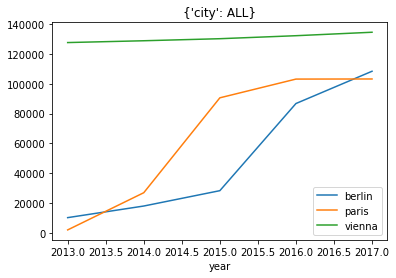

In [13]:
# Plot it in a .jpg picture
data.plot(city=ALL, filename='example.png')

In [15]:
# Or get it as a .csv
print(data.select(city=ALL).getCSV())

year,berlin,paris,vienna
2013.0,10180,1936,127690
2014.0,17971,26905,128906
2015.0,28277,90602,130279
2016.0,86769,103175,132294
2017.0,108432,103249,134617



# Can we get the streets from Edinburgh ?

Following the indications in :
    
https://automating-gis-processes.github.io/site/notebooks/L6/retrieve_osm_data.html

In [8]:
import osmnx as ox
import matplotlib.pyplot as plt
%matplotlib inline

# Specify the name that is used to seach for the data
place_name = "Bruntsfield, Edinburgh, Scotland"

# Fetch OSM street network from the location
graph = ox.graph_from_place(place_name)

In [9]:
type(graph)

networkx.classes.multidigraph.MultiDiGraph

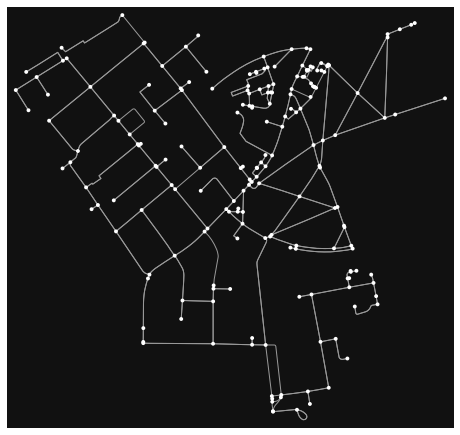

In [25]:
# Plot the streets
fig, ax = ox.plot_graph(graph)

<AxesSubplot:>

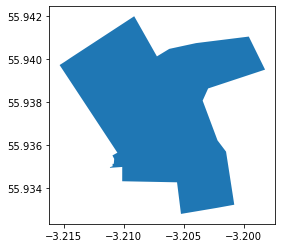

In [26]:
area = ox.geocode_to_gdf(place_name)
area.plot()

In [71]:
# as per changelog here: https://github.com/gboeing/osmnx/issues/526

buildings = ox.geometries_from_place(place_name, tags={'building':True})

tags = {'amenity':True, 'landuse':['restaurant']}
restaurants = ox.geometries_from_place(place_name, tags)

nodes, edges = ox.graph_to_gdfs(graph)

tags = {'amenity':True, 'landuse':['leisure']}
leisure = ox.geometries_from_place(place_name, tags)

C:\Users\darkj\miniconda3\envs\gis_lab\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [72]:
from pyproj import CRS

# Set projection
projection = CRS.from_epsg(3067)

# Re-project layers
area = area.to_crs(projection)
edges = edges.to_crs(projection)
buildings = buildings.to_crs(projection)
restaurants = restaurants.to_crs(projection)
leisure = leisure.to_crs(projection)

C:\Users\darkj\miniconda3\envs\gis_lab\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [51]:
%matplotlib inline

C:\Users\darkj\miniconda3\envs\gis_lab\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


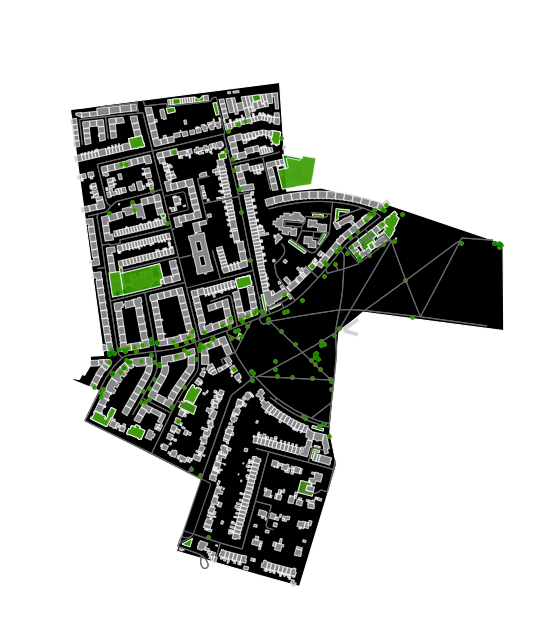

In [73]:
plt.style.use("dark_background")

fig, ax = plt.subplots(figsize=(12,8))

fig.patch.set_alpha(0)

# Plot the footprint
area.plot(ax=ax, facecolor='black')

# Plot street edges
edges.plot(ax=ax, linewidth=1, edgecolor='dimgray')

# Plot buildings
buildings.plot(ax=ax, facecolor='silver', alpha=0.7)

# Plot restaurants
restaurants.plot(ax=ax, color='yellow', alpha=0.7, markersize=10)

# Plot restaurants
leisure.plot(ax=ax, color='green', alpha=0.7, markersize=10)


plt.axis('off')

plt.tight_layout()